In [1]:
## Importamos todas las librerías que vamos a utilizar
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split,StratifiedKFold,StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import joblib 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/datasetheartdisease/dataset.csv


## Visualización inicial de los datos
Hacemos una visualización inicial de los datos, observando que todos los datos están transfromados a datos numéricos. También eliminamos una columna que se nos creó cuando transformamos el dataset. 

In [2]:
data=pd.read_csv("/kaggle/input/datasetheartdisease/dataset.csv")
df=data.copy()
df=df.drop(["Unnamed: 0"],axis=1)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,8,17,1,1,5,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,8,22,0,1,5,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,9,19,1,1,3,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,8,21,0,0,4,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,8,14,0,1,5,8.0,0,0,0


# Separamos los datos
Separamos los datos de nuestro dataset, ponemos las características que vamos a utilizar para entrenar en la variable X y la variable a predecir en la varibale Y.

In [3]:
X=df.iloc[:,1:17]
Y=df.iloc[:,0]

# Estandarización de los datos
Usamos StandardScaler para estandarizar las caracteríticas que vamos a usar para entrenar en nuestro modelo.

In [4]:
scaler=StandardScaler()
columns=X.columns
s=scaler.fit_transform(X)
scaled_data=pd.DataFrame(s,columns=columns)
scaled_data.head(5)

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,-1.844750,1.193474,-0.27032,-0.198040,-0.046751,3.281069,-0.401578,-0.951711,0.136184,2.524911,0.538256,0.388307,-1.460354,2.541515,-0.195554,3.118419
1,-1.256338,-0.837890,-0.27032,5.049478,-0.424070,-0.490039,-0.401578,-0.951711,1.538806,-0.396054,0.538256,0.388307,-0.067601,-0.393466,-0.195554,-0.320675
2,-0.274603,1.193474,-0.27032,-0.198040,2.091388,3.281069,-0.401578,1.050739,0.697233,2.524911,0.538256,-1.529392,0.628776,2.541515,-0.195554,-0.320675
3,-0.647473,-0.837890,-0.27032,-0.198040,-0.424070,-0.490039,-0.401578,-0.951711,1.258282,-0.396054,-1.857852,-0.570542,-0.763977,-0.393466,-0.195554,3.118419
4,-0.726138,-0.837890,-0.27032,-0.198040,3.097572,-0.490039,2.490174,-0.951711,-0.705388,-0.396054,0.538256,0.388307,0.628776,-0.393466,-0.195554,-0.320675


# Validación cruzada
Utilizamos StratifiedKFold para hacer la validación cruzada ya que tenemos un dataset desbalanceado. Se utilizarán 5 folds. Tratamos de encontrar los mejores parámetros para que el modelo tenga el mejor rendimiento. Vamos a variar el learning_rate, n_estimators y max_features. Learning_rate va a variar entre los siguiente valores 0.1,0.8,1,5,10. N_estimators va a variar entre los siguiente valores 10,50,100,150. Max_features va a variar entre los siguiente valores 3,8,12,16.   
Como métricas de rendimiento utilizaremos F1 Score, Recall y Accuracy

In [5]:
learning_rate=[0.1,0.8,1,5,10]
n_estimators=[10,50,100,150]
max_features=[3,8,12,16]
folds=5
skf=StratifiedKFold(n_splits=folds)
resultados = {
    'learning_rate': [],
    'n_estimators': [],
    'max_features': [],
    'F1 Score (Mean)': [],
    'F1 Score (IC)': [],
    'Sensibilidad-Recall (Mean)': [],
    'Sensibilidad-Recall (IC)': [],
    'Accuracy (Mean)':[],
    'Accuracy (IC)':[]
}
for rate in learning_rate:
    for n_estimator in n_estimators:
        for features in max_features:
            recall_temp = []
            accuracy_temp = []
            f1score_temp=[]
            for train, test in skf.split(X=scaled_data,y=Y):
                Xtrain, Xtest = scaled_data.iloc[train], scaled_data.iloc[test]
                Ytrain, Ytest = Y[train], Y[test]

                model=GradientBoostingClassifier(learning_rate=0.1,n_estimators=n_estimator,
                                                 max_features=features,
                                                 random_state=0                                                     
                                                )
                model.fit(Xtrain,Ytrain)

                Yest=model.predict(Xtest)
                vn, fp, fn, vp = confusion_matrix(y_true =Ytest  , y_pred = Yest ).ravel()
                recall_temp.append(recall_score(Ytest,Yest))
                f1score_temp.append(f1_score(y_true=Ytest,y_pred=Yest))
                accuracy_temp.append(accuracy_score(Ytest,Yest))
            resultados['learning_rate'].append(rate)
            resultados['n_estimators'].append(n_estimator)
            resultados['max_features'].append(features)
            resultados['Sensibilidad-Recall (Mean)'].append(np.mean(recall_temp))
            resultados['Sensibilidad-Recall (IC)'].append(np.std(recall_temp))
            resultados['F1 Score (Mean)'].append(np.mean(f1score_temp))
            resultados['F1 Score (IC)'].append(np.std(f1score_temp))
            resultados['Accuracy (Mean)'].append(np.mean(accuracy_temp))
            resultados['Accuracy (IC)'].append(np.std(accuracy_temp))  

resultados = pd.DataFrame(resultados)
resultados


,learning_rate,n_estimators,max_features,F1 Score (Mean),F1 Score (IC),Sensibilidad-Recall (Mean),Sensibilidad-Recall (IC),Accuracy (Mean),Accuracy (IC)
0,0.1,10,3,0.000000,0.000000,0.000000,0.000000,0.914405,0.000008
1,0.1,10,8,0.003787,0.002249,0.001900,0.001129,0.914526,0.000072
2,0.1,10,12,0.000000,0.000000,0.000000,0.000000,0.914405,0.000008
3,0.1,10,16,0.001019,0.002039,0.000511,0.001023,0.914436,0.000060
4,0.1,50,3,0.128471,0.010609,0.072553,0.007000,0.915846,0.000355
...,...,...,...,...,...,...,...,...,...
75,10.0,100,16,0.153664,0.009715,0.089176,0.006666,0.915990,0.000366
76,10.0,150,3,0.155176,0.009069,0.090272,0.006548,0.915943,0.000231
77,10.0,150,8,0.155831,0.008496,0.090527,0.006108,0.916115,0.000384
78,10.0,150,12,0.156875,0.009778,0.091477,0.006815,0.915909,0.000350


# Resultados de la validación cruzada
Acá observamos los resultados de la validación cruzada, ordenados de manera descendente con respecto al valor obtenido para el F1 Score y el Recall.

In [6]:
resultados.sort_values(by = ['F1 Score (Mean)', 'Sensibilidad-Recall (Mean)'], ascending = [False, False]).head(10)

,learning_rate,n_estimators,max_features,F1 Score (Mean),F1 Score (IC),Sensibilidad-Recall (Mean),Sensibilidad-Recall (IC),Accuracy (Mean),Accuracy (IC)
10,0.1,100,12,0.157577,0.010888,0.091879,0.007654,0.916006,0.000284
26,0.8,100,12,0.157577,0.010888,0.091879,0.007654,0.916006,0.000284
42,1.0,100,12,0.157577,0.010888,0.091879,0.007654,0.916006,0.000284
58,5.0,100,12,0.157577,0.010888,0.091879,0.007654,0.916006,0.000284
74,10.0,100,12,0.157577,0.010888,0.091879,0.007654,0.916006,0.000284
14,0.1,150,12,0.156875,0.009778,0.091477,0.006815,0.915909,0.000350
30,0.8,150,12,0.156875,0.009778,0.091477,0.006815,0.915909,0.000350
46,1.0,150,12,0.156875,0.009778,0.091477,0.006815,0.915909,0.000350
62,5.0,150,12,0.156875,0.009778,0.091477,0.006815,0.915909,0.000350
78,10.0,150,12,0.156875,0.009778,0.091477,0.006815,0.915909,0.000350


# Graficas de Rendimiento

## F1 Score, Recall y Accuracy con respecto al Learning Rate

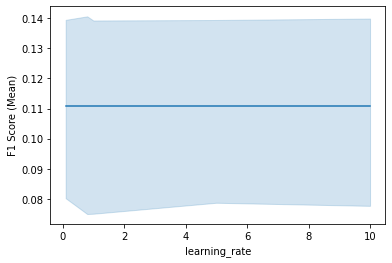

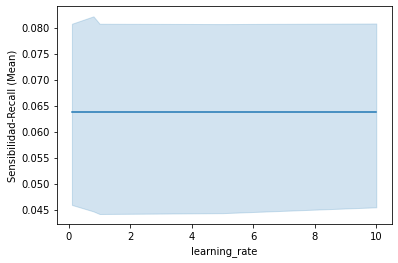

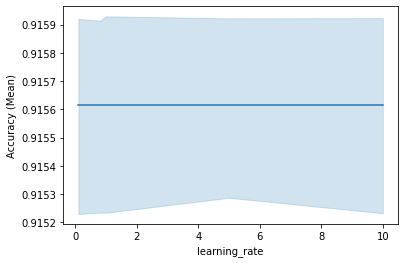

In [7]:
errores=["F1 Score (Mean)","Sensibilidad-Recall (Mean)","Accuracy (Mean)"]
for error in errores:
    sns.lineplot(data=resultados,x="learning_rate",y=error)
    plt.show()

## F1 Score, Recall y Accuracy con respecto a N Estimators

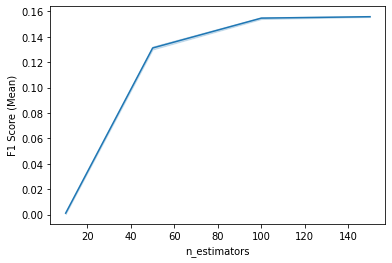

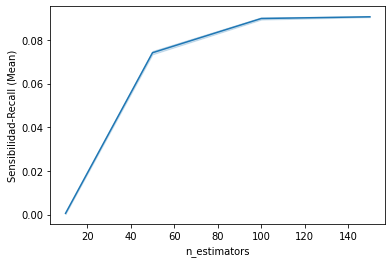

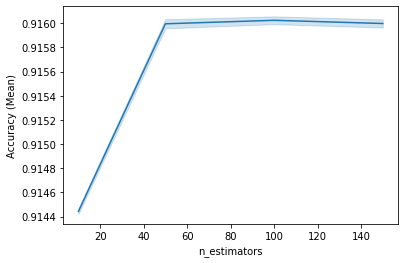

In [8]:
for error in errores:
    sns.lineplot(data=resultados,x="n_estimators",y=error)
    plt.show()

## F1 Score, Recall y Accuracy con respecto a Max Features

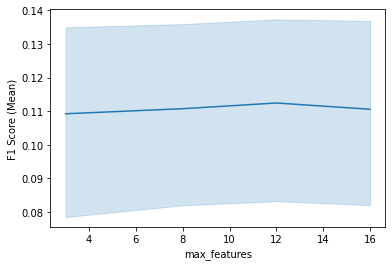

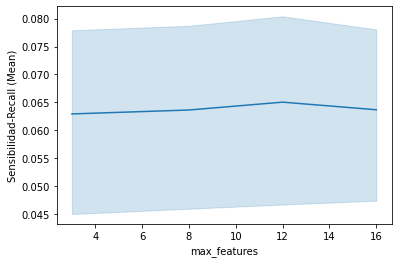

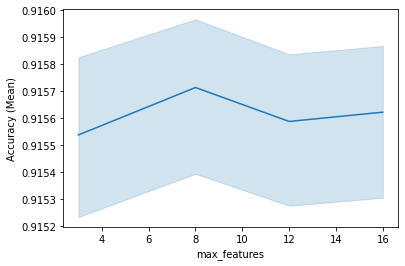

In [9]:
for error in errores:
    sns.lineplot(data=resultados,x="max_features",y=error)
    plt.show()

# Partición de los datos
Partimos los datos en train y test en una proporción 70-30. 70% de los datos para entrenar el modelo y 30% de los datos para la validación del mismo.

In [10]:
X_train,X_test,y_train,y_test=train_test_split(scaled_data,
                                               Y,
                                               test_size=0.3,
                                               random_state=50)

# Cantidad de datos que hay para una clases a predecir

In [11]:
counter=Counter(y_train)
print(counter)

Counter({0: 204624, 1: 19232})


# Función para el entrenamiento de los modelos

In [12]:
def entrenarModelo(model_train, Xtrain,Ytrain,Xtest,Ytest):
    model.fit(X=Xtrain,y=Ytrain)
    Ypred=model.predict(Xtest)

    print(f'Model: {str(model)}')
    print(f'Accuracy Score: {accuracy_score(Ytest,Ypred)}')
    print(f'Precission Score: {precision_score(Ytest,Ypred)}')
    print(f'Recall Score: {recall_score(Ytest,Ypred)}')
    print(f'F1-Score: {f1_score(Ytest,Ypred)}')
    cm = confusion_matrix(Ytest, Ypred, labels=model_train.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_train.classes_)
    disp.plot()
    return model_train


# Función para realizar el Submuestreo de los datos

In [13]:
def balancearClases(balanceador, X_train, y_train):
    Xtrain_new, Ytrain_new=balanceador.fit_resample(X_train,y_train)
    print("Dimensiones")
    print("Xtrain_new: ", Xtrain_new.shape)
    print("Ytrain_new: ", Ytrain_new.shape)
    return Xtrain_new,Ytrain_new

# Entrenamiento del modelo con UnderSampling

In [14]:
subsample=RandomUnderSampler()
Xtrain_new, Ytrain_new=balancearClases(subsample, X_train, y_train)

Dimensiones
Xtrain_new:  (38464, 16)
Ytrain_new:  (38464,)


Model: GradientBoostingClassifier(n_estimators=150, random_state=0)
Accuracy Score: 0.7351025130551705
Precission Score: 0.21608205397942076
Recall Score: 0.8073946689595872
F1-Score: 0.34092323651452283


['GradientBoosting_UnderSampling.joblib']

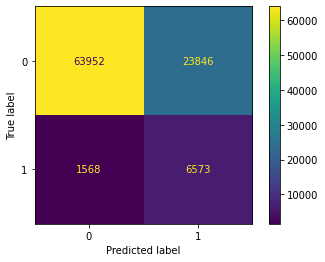

In [15]:
model=GradientBoostingClassifier(n_estimators=150,random_state=0)
modelo_entrenado=entrenarModelo(model,Xtrain_new,Ytrain_new,X_test,y_test)
joblib.dump(modelo_entrenado, 'GradientBoosting_UnderSampling.joblib') 

# Entrenamiento del modelo con OverSampling

In [16]:
subsample=RandomOverSampler()
Xtrain_new, Ytrain_new=balancearClases(subsample, X_train, y_train)

Dimensiones
Xtrain_new:  (409248, 16)
Ytrain_new:  (409248,)


Model: GradientBoostingClassifier(n_estimators=150, random_state=0)
Accuracy Score: 0.7354464816185284
Precission Score: 0.21624201724932518
Recall Score: 0.8069033288293821
F1-Score: 0.341078428827332


['GradientBoosting_OverSampling.joblib']

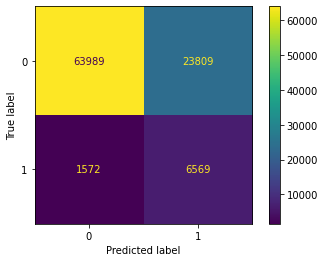

In [17]:
model=GradientBoostingClassifier(n_estimators=150,random_state=0)
modelo_entrenado=entrenarModelo(model,Xtrain_new,Ytrain_new,X_test,y_test)
joblib.dump(modelo_entrenado, 'GradientBoosting_OverSampling.joblib') 

# Entrenamiento del modelo sin ninguna técnica de submuestreo

Model: GradientBoostingClassifier(n_estimators=150, random_state=0)
Accuracy Score: 0.9167491843775732
Precission Score: 0.5578947368421052
Recall Score: 0.09114359415305245
F1-Score: 0.15668883961566887


['GradientBoosting.joblib']

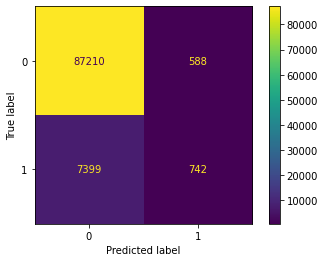

In [18]:
model=GradientBoostingClassifier(n_estimators=150,random_state=0)
modelo_entrenado=entrenarModelo(model,X_train,y_train,X_test,y_test)
joblib.dump(modelo_entrenado, 'GradientBoosting.joblib') 